In [1]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DAE_np_data_path = r'data\np\X4sShowX4StdOut.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [3]:
# A dataset of 
np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

,DatasetID,year1,author1,y:Value,y,dy,x1:ResEn,x1(eV),dx1(eV),x2:IncEn,...,Proj,Emiss,Prod1,MF,MT,ReacType,Quant1,nx,indVars,Reacode
205,13530002,1993,B.K.Park+,Data(B/SR/EV),2.332000e-07,6.086000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
206,13530002,1993,B.K.Park+,Data(B/SR/EV),1.133000e-07,4.229000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
207,13530002,1993,B.K.Park+,Data(B/SR/EV),8.373000e-08,3.650000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
208,13530002,1993,B.K.Park+,Data(B/SR/EV),0.000000e+00,0.000000e+00,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
209,13530002,1993,B.K.Park+,Data(B/SR/EV),3.774000e-07,7.774000e-08,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13552,13530013,1993,B.K.Park+,Data(B/SR/EV),6.241000e-07,1.777000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13553,13530013,1993,B.K.Park+,Data(B/SR/EV),7.420000e-07,1.948000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13554,13530013,1993,B.K.Park+,Data(B/SR/EV),6.237000e-07,1.786000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"
13555,13530013,1993,B.K.Park+,Data(B/SR/EV),1.247000e-06,2.536000e-07,NaN,NaN,NaN,EN(EV),...,N,P,15-P-32,6,103,DAE,DAE,3,234,"16-S-32(N,P)15-P-32,,DA/DE"


In [21]:
df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section --> Could use this to weigh the KL loss (IDEA)

})

# df['E_inc'] = df['E_inc'] / 1e6  # eV → MeV
# df['E_sec'] = df['E_sec'] / 1e6  # eV → MeV

# Drop rows with missing values
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df['theta'].unique()

array([ 2,  1,  3,  5,  7,  9, 11, 13])

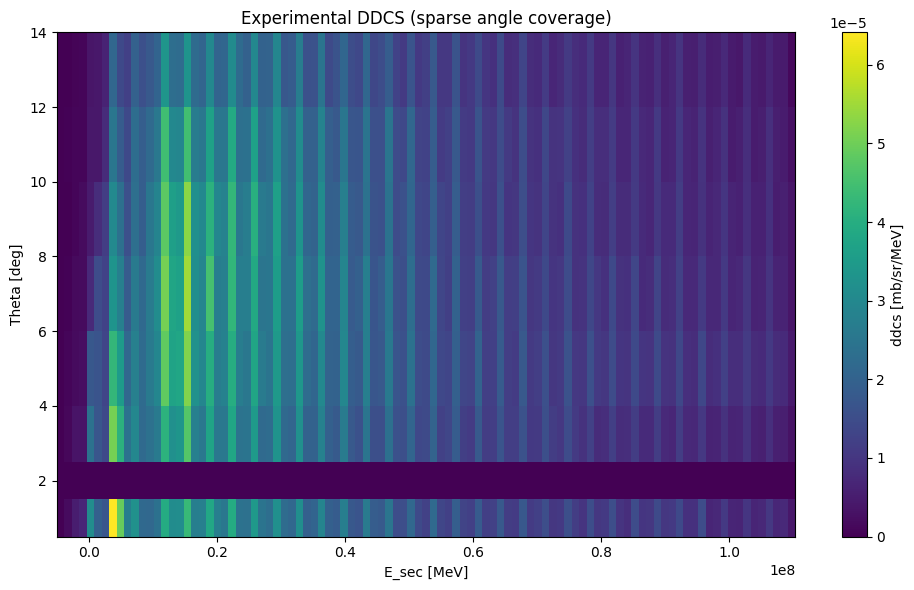

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Unique sorted angles
unique_thetas = np.sort(df['theta'].unique())
E_bins = np.linspace(df['E_sec'].min(), df['E_sec'].max(), 100)

# Create a 2D array of shape (n_theta, n_E_bins)
heatmap = np.zeros((len(unique_thetas), len(E_bins) - 1))

# Fill in the heatmap row-by-row
for i, theta in enumerate(unique_thetas):
    subset = df[df['theta'] == theta]
    hist, _ = np.histogram(
        subset['E_sec'], bins=E_bins,
        weights=subset['ddcs']
    )
    heatmap[i] = hist

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
E_centers = 0.5 * (E_bins[:-1] + E_bins[1:])
pcm = ax.pcolormesh(E_centers, unique_thetas, heatmap, shading='auto', cmap='viridis')
fig.colorbar(pcm, ax=ax, label='ddcs [mb/sr/MeV]')
ax.set_xlabel('E_sec [MeV]')
ax.set_ylabel('Theta [deg]')
ax.set_title('Experimental DDCS (sparse angle coverage)')
plt.tight_layout()
plt.show()


In [6]:
print(np.sort(df['theta'].unique()))

[ 1  2  3  5  7  9 11 13]


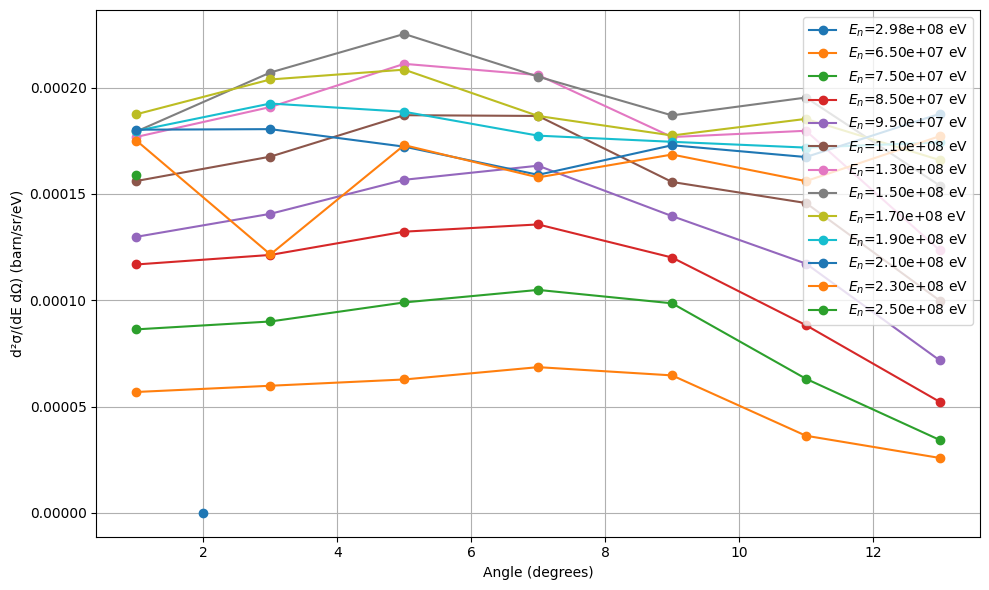

In [7]:
angle_max = np.max(df['theta'].unique())
unique_angles = np.sort(df['theta'].unique())

# energies_to_plot = np.linspace(df['E_inc'].min(), df['E_inc'].max(), 10)  # 10 evenly spaced energies
energies_to_plot = df['E_inc'].unique()
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    if E_n in (65,298):
        continue
    
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance] 
    if df_slice.empty:
        continue
    
    # grouped = df_slice.groupby('theta')['ddcs'].sum()
    # # Align grouped with full angle range
    # y_vals = np.array([grouped.get(angle) for angle in unique_angles])
    
    # plt.plot(unique_angles, y_vals, marker='o', label=rf"$E_n$={E_n:.2f} MeV")
    grouped = df_slice.groupby('theta')['ddcs'].sum()
    angles_present = grouped.index.to_numpy()
    y_vals = grouped.to_numpy()

    plt.plot(angles_present, y_vals, marker='o', label=rf"$E_n$={E_n:.2e} eV")

plt.xlabel("Angle (degrees)")
plt.ylabel("d²σ/(dE dΩ) (barn/sr/eV)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional log scale for better visibility
plt.show()


In [24]:
# Group data by angle
grouped = df.groupby('theta')

# Store results here
dsigma_dOmega = []

for angle, group in grouped:
    # Sort by energy to ensure correct integration
    group_sorted = group.sort_values('E_sec')

    # Numerical integration using the trapezoidal rule
    integral = np.trapezoid(group_sorted['ddcs'], group_sorted['E_sec'])

    dsigma_dOmega.append({'theta': angle, 'dsigma_dOmega': integral})

# Create final DataFrame
df_result = pd.DataFrame(dsigma_dOmega)

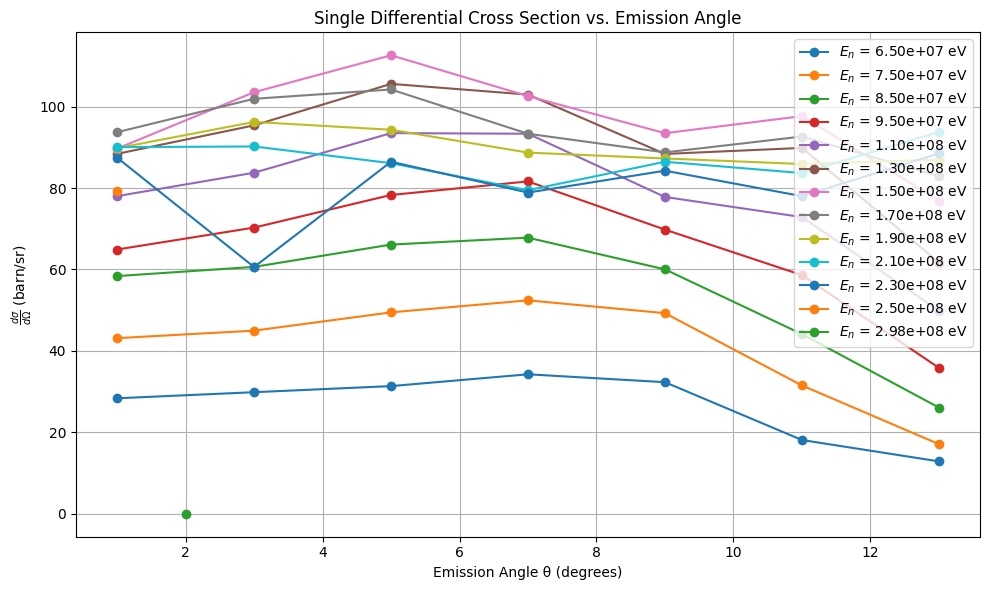

In [8]:
# Get sorted unique incident energies and angles
energies_to_plot = np.sort(df['E_inc'].unique())
unique_angles = np.sort(df['theta'].unique())
tolerance = 0.05  # MeV

plt.figure(figsize=(10, 6))

for E_n in energies_to_plot:
    if E_n in (65, 298):  # skipping unwanted energies
        continue

    # Select data near the current incident energy
    df_slice = df[np.abs(df['E_inc'] - E_n) < tolerance]
    if df_slice.empty:
        continue

    # Group by angle and integrate DDCS over E_sec
    dsigma_dOmega_vals = []
    angles_present = []

    for angle, group in df_slice.groupby('theta'):
        # Sort by emitted proton energy
        group_sorted = group.sort_values('E_sec')
        # Perform numerical integration over E_sec
        integral = np.trapezoid(group_sorted['ddcs'], group_sorted['E_sec'])
        dsigma_dOmega_vals.append(integral)
        angles_present.append(angle)

    # Plot dsigma/dOmega vs angle
    plt.plot(angles_present, dsigma_dOmega_vals, marker='o', label=rf"$E_n$ = {E_n:.2e} eV")

plt.xlabel("Emission Angle θ (degrees)")
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ (barn/sr)")
plt.title("Single Differential Cross Section vs. Emission Angle")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # optional
plt.show()

In [ ]:
def simulate_ddcs(random_tensor, E_n_lab, N_theta_bins=13, N_E_bins=100, device = 'cpu'):
    """
    Simulates DDCS for the reaction 32S(n,p)32P.
    
    Parameters:
        random_tensor (torch.Tensor): 1D tensor of uniform random numbers in [0, 1], length N_samples
        E_n_lab (float): Incident neutron energy in MeV (lab frame)
        N_theta_bins (int): Number of angular bins (0-180 deg)
        N_E_bins (int): Number of energy bins for emitted proton
    
    Returns:
        ddcs (torch.Tensor): 2D histogram [theta_bin, energy_bin]
        theta_edges (torch.Tensor), E_edges (torch.Tensor): Bin edges
    """
    # assert random_tensor.ndim == 1, "Input must be 1D tensor"
    device = torch.device(device)
    dtype = random_tensor.dtype
    N_samples = len(random_tensor)

    # Atomic masses (u), converted to MeV
    u_to_MeV = torch.tensor(931.494, device=device, dtype=dtype)
    m_n = torch.tensor(1.008664, device=device, dtype=dtype) * u_to_MeV
    m_p = torch.tensor(1.007276, device=device, dtype=dtype) * u_to_MeV
    m_S = torch.tensor(31.972071, device=device, dtype=dtype) * u_to_MeV
    m_P = torch.tensor(31.973907, device=device, dtype=dtype) * u_to_MeV

    Q = (m_S + m_n - m_P - m_p)  # Q-value in MeV

    # Sample angles isotropically in CM frame
    cos_theta_cm = 2 * random_tensor - 1
    theta_cm_rad = torch.acos(cos_theta_cm)  # in radians
    theta_deg = torch.rad2deg(theta_cm_rad)

    # Reduced mass of initial system
    M_tot = m_n + m_S
    mu_in = (m_n * m_S) / M_tot

    # CM energy
    E_cm = mu_in * E_n_lab / m_n

    # Available energy in CM
    E_available = E_cm + Q

    # Reduced mass of final system
    mu_out = (m_p * m_P) / (m_p + m_P)

    # CM momentum of outgoing proton
    p_cm = torch.sqrt(2 * mu_out * E_available)

    # Velocity of CM
    v_cm = m_n * torch.sqrt(2 * E_n_lab / m_n) / M_tot

    # Proton velocity in CM frame
    v_p_cm = p_cm / m_p

    # Compute lab-frame proton energy
    E_p_lab = 0.5 * m_p * (v_p_cm**2 + v_cm**2 + 2 * v_p_cm * v_cm * cos_theta_cm)
    E_p_lab = E_p_lab / u_to_MeV  # Convert to MeV

    # Bin the results into (theta, E_p) histogram
    theta_bins = torch.linspace(0, N_theta_bins, N_theta_bins + 1, device=device, dtype=dtype)
    E_bins = torch.linspace(0, torch.max(E_p_lab)*1.05, N_E_bins + 1, device=device, dtype=dtype)

    # Create 2D histogram using PyTorch
    theta_indices = torch.bucketize(theta_deg, theta_bins) - 1
    E_indices = torch.bucketize(E_p_lab, E_bins) - 1
    
    # Filter out out-of-bounds values
    mask = (theta_indices >= 0) & (theta_indices < N_theta_bins) & \
           (E_indices >= 0) & (E_indices < N_E_bins)
    theta_indices = theta_indices[mask]
    E_indices = E_indices[mask]
    
    # Create 2D histogram
    ddcs = torch.zeros((N_theta_bins, N_E_bins), device=device, dtype=dtype)
    ddcs.index_put_((theta_indices, E_indices), torch.ones_like(theta_indices, dtype=dtype), accumulate=True)

    # Normalize to probability density
    ddcs = ddcs / ddcs.sum()

    return ddcs, theta_bins, E_bins


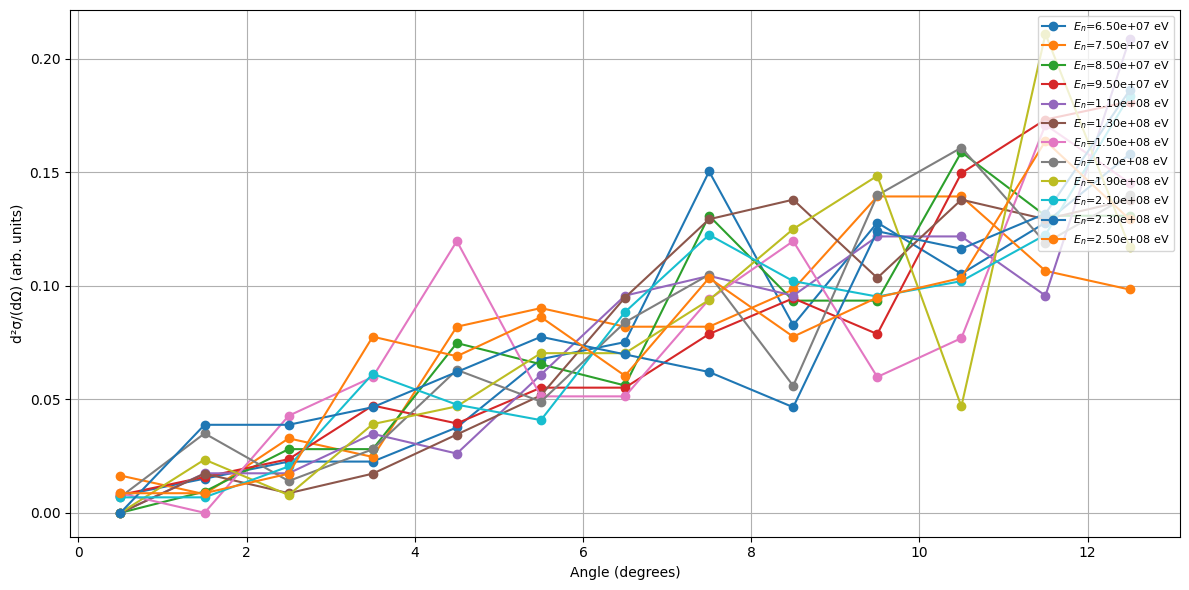

In [15]:
# Simulation neutron energies to match your experiment
energies_to_plot = [6.5e7, 7.5e7, 8.5e7, 9.5e7, 1.1e8, 1.3e8, 1.5e8, 1.7e8, 1.9e8, 2.1e8, 2.3e8, 2.5e8]  # eV
energies_to_plot = [E / 1e6 for E in energies_to_plot]  # convert to MeV

plt.figure(figsize=(12, 6))

for E_n in energies_to_plot:
    # Generate a batch of random samples for simulation
    rand_samples = torch.rand(1_000_0)
    
    # Run simulation for given E_n
    ddcs, theta_edges, E_edges = simulate_ddcs(rand_samples, N_theta_bins=13, E_n_lab=E_n)
    
    # Sum over energy to mimic experimental grouping: DDCS vs angle
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
    ddcs_vs_angle = ddcs.sum(axis=1)  # sum over energy axis

    # Plot
    plt.plot(theta_centers, ddcs_vs_angle, marker='o', label=rf"$E_n$={E_n*1e6:.2e} eV")

plt.xlabel("Angle (degrees)")
plt.ylabel(r"d²σ/(dΩ) (arb. units)")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from torch.autograd import Function
import torch.nn as nn

# simulate_ddcs(random_tensor, E_n_lab, N_theta_bins, N_E_bins=100, device = 'cpu'):

# -- Register this function first --
class SimulationFunction(Function):
    @staticmethod
    def forward(ctx, uniform_samples):
        results = simulate_ddcs(
            uniform_samples,
            
        )
        return ...

    @staticmethod
    def backward(ctx, grad_output):
        ...
        return ...

# -- Drop-in Module Layer --
class HiggsSimulationLayer(nn.Module):
    def forward(self, uniform_samples):
        ...
        return SimulationFunction.apply(uniform_samples)



In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

class RandomNumberGenerator(nn.Module):
    """
    Neural network that generates non-uniform random numbers conditioned on neutron energy.
    Takes uniform random samples and neutron energy as input, outputs transformed random numbers.
    """
    def __init__(self, n_samples, hidden_dims=[128, 256, 128]):
        super().__init__()
        self.n_samples = n_samples
        
        # Input: uniform random samples + neutron energy
        input_dim = n_samples + 1  # +1 for E_n
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        # Output layer - same size as input random samples
        layers.append(nn.Linear(prev_dim, n_samples))
        layers.append(nn.Sigmoid())  # Ensure output is in [0,1]
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, uniform_random, E_n):
        """
        Args:
            uniform_random: (batch_size, n_samples) - uniform random numbers
            E_n: (batch_size, 1) - neutron energies
        """
        inputs = torch.cat([uniform_random, E_n], dim=1)
        return self.network(inputs)

def simulate_ddcs_angular(random_tensors, E_n_values, theta_bins_deg, device='cpu'):
    """
    Modified simulation that returns angular distributions matching experimental theta bins.
    Uses differentiable soft histogramming to maintain gradients.
    
    Args:
        random_tensors: (batch_size, n_samples) - random numbers for each batch item
        E_n_values: (batch_size,) - neutron energies for each batch item
        theta_bins_deg: array-like - experimental theta values in degrees
    
    Returns:
        angular_ddcs: (batch_size, n_theta_bins) - angular distributions for each batch item
    """
    batch_size = random_tensors.shape[0]
    device = torch.device(device)
    dtype = random_tensors.dtype
    n_theta_bins = len(theta_bins_deg)
    
    # Constants - ensure they're on the right device and have gradients
    u_to_MeV = torch.tensor(931.494, device=device, dtype=dtype, requires_grad=False)
    m_n = torch.tensor(1.008664, device=device, dtype=dtype, requires_grad=False) * u_to_MeV
    m_p = torch.tensor(1.007276, device=device, dtype=dtype, requires_grad=False) * u_to_MeV
    m_S = torch.tensor(31.972071, device=device, dtype=dtype, requires_grad=False) * u_to_MeV
    m_P = torch.tensor(31.973907, device=device, dtype=dtype, requires_grad=False) * u_to_MeV
    Q = (m_S + m_n - m_P - m_p)
    
    # Convert theta bins to tensor
    theta_bins_tensor = torch.tensor(theta_bins_deg, device=device, dtype=dtype, requires_grad=False)
    
    # Store all angular histograms
    angular_hists = []
    
    # Process all samples at once (vectorized)
    for i in range(batch_size):
        random_tensor = random_tensors[i]
        E_n_lab = E_n_values[i]
        
        # Physics calculations - all differentiable
        cos_theta_cm = 2 * random_tensor - 1
        
        # Clamp to avoid numerical issues with acos
        cos_theta_cm = torch.clamp(cos_theta_cm, -0.9999, 0.9999)
        theta_cm_rad = torch.acos(cos_theta_cm)
        theta_deg = theta_cm_rad * 180.0 / torch.pi  # More numerically stable than rad2deg
        
        M_tot = m_n + m_S
        mu_in = (m_n * m_S) / M_tot
        E_cm = mu_in * E_n_lab / m_n
        E_available = E_cm + Q
        mu_out = (m_p * m_P) / (m_p + m_P)
        
        # Ensure positive value under sqrt
        sqrt_arg = 2 * mu_out * E_available
        sqrt_arg = torch.clamp(sqrt_arg, min=1e-8)
        p_cm = torch.sqrt(sqrt_arg)
        
        v_cm = m_n * torch.sqrt(torch.clamp(2 * E_n_lab / m_n, min=1e-8)) / M_tot
        v_p_cm = p_cm / m_p
        
        E_p_lab = 0.5 * m_p * (v_p_cm**2 + v_cm**2 + 2 * v_p_cm * v_cm * cos_theta_cm)
        E_p_lab = E_p_lab / u_to_MeV
        
        # Use soft histogramming to maintain differentiability
        angular_hist = soft_histogram(theta_deg, theta_bins_tensor, sigma=0.5)
        
        # Normalize
        angular_hist = angular_hist / (angular_hist.sum() + 1e-8)
        
        angular_hists.append(angular_hist)
    
    # Stack all histograms into a single tensor
    angular_ddcs = torch.stack(angular_hists, dim=0)
    
    return angular_ddcs

def soft_histogram(values, bin_centers, sigma=1.0):
    """
    Differentiable soft histogram using Gaussian kernels.
    
    Args:
        values: (n_samples,) - values to histogram
        bin_centers: (n_bins,) - bin center positions
        sigma: width of Gaussian kernels
    
    Returns:
        hist: (n_bins,) - soft histogram counts
    """
    # Expand dimensions for broadcasting
    values_expanded = values.unsqueeze(1)  # (n_samples, 1)
    bins_expanded = bin_centers.unsqueeze(0)  # (1, n_bins)
    
    # Compute Gaussian weights
    weights = torch.exp(-0.5 * ((values_expanded - bins_expanded) / sigma) ** 2)
    
    # Sum over samples to get histogram
    hist = weights.sum(dim=0)
    
    return hist

def prepare_experimental_data(df, theta_values):
    """
    Prepare experimental data from pandas DataFrame.
    
    Args:
        df: pandas DataFrame with columns ['E_inc', 'E_sec', 'theta', 'ddcs', 'Errddcs']
        theta_values: array of unique theta values
    
    Returns:
        E_inc_values: tensor of unique incident energies in MeV
        experimental_ddcs: tensor of shape (n_energies, n_theta_bins)
        experimental_errors: tensor of shape (n_energies, n_theta_bins)
        valid_mask: tensor of shape (n_energies, n_theta_bins) - True where data exists
    """
    # Get unique incident energies and convert from eV to MeV
    E_inc_unique_eV = np.sort(df['E_inc'].unique())
    E_inc_unique = E_inc_unique_eV * 1e-6  # Convert eV to MeV
    n_energies = len(E_inc_unique)
    n_theta = len(theta_values)
    
    print(f"Experimental energies (eV): {E_inc_unique_eV}")
    print(f"Experimental energies (MeV): {E_inc_unique}")
    
    # Initialize arrays
    experimental_ddcs = np.full((n_energies, n_theta), np.nan)  # Use NaN instead of 0
    experimental_errors = np.full((n_energies, n_theta), np.nan)
    valid_mask = np.zeros((n_energies, n_theta), dtype=bool)
    
    # Fill the arrays
    for i, E_inc_eV in enumerate(E_inc_unique_eV):
        energy_data = df[df['E_inc'] == E_inc_eV]
        
        for j, theta in enumerate(theta_values):
            theta_data = energy_data[energy_data['theta'] == theta]
            
            if not theta_data.empty:
                # If multiple entries for same E_inc, theta, take the mean
                experimental_ddcs[i, j] = theta_data['ddcs'].mean()
                experimental_errors[i, j] = theta_data['Errddcs'].mean()
                valid_mask[i, j] = True
    
    # Handle missing data by interpolation across theta for each energy
    for i in range(n_energies):
        valid_indices = valid_mask[i, :]
        if np.sum(valid_indices) > 1:  # Need at least 2 points to interpolate
            valid_theta = theta_values[valid_indices]
            valid_ddcs = experimental_ddcs[i, valid_indices]
            valid_errors = experimental_errors[i, valid_indices]
            
            # Interpolate missing values
            if np.sum(~valid_indices) > 0:  # There are missing values
                from scipy.interpolate import interp1d
                
                # Linear interpolation for DDCS
                f_ddcs = interp1d(valid_theta, valid_ddcs, kind='linear', 
                                bounds_error=False, fill_value='extrapolate')
                experimental_ddcs[i, ~valid_indices] = f_ddcs(theta_values[~valid_indices])
                
                # Linear interpolation for errors
                f_errors = interp1d(valid_theta, valid_errors, kind='linear',
                                  bounds_error=False, fill_value='extrapolate')
                experimental_errors[i, ~valid_indices] = f_errors(theta_values[~valid_indices])
                
                # Update valid mask
                valid_mask[i, :] = True
    
    # Remove energies that have no valid data at all
    energies_with_data = np.any(valid_mask, axis=1)
    E_inc_unique = E_inc_unique[energies_with_data]
    experimental_ddcs = experimental_ddcs[energies_with_data]
    experimental_errors = experimental_errors[energies_with_data]
    valid_mask = valid_mask[energies_with_data]
    
    # Ensure no NaN values remain
    experimental_ddcs = np.nan_to_num(experimental_ddcs, nan=1e-10, posinf=1e10, neginf=1e-10)
    experimental_errors = np.nan_to_num(experimental_errors, nan=1.0, posinf=1e10, neginf=1e-10)
    
    # Ensure positive values
    experimental_ddcs = np.maximum(experimental_ddcs, 1e-10)
    experimental_errors = np.maximum(experimental_errors, 1e-10)
    
    print(f"Final data shape: {experimental_ddcs.shape}")
    print(f"Energy range (MeV): {E_inc_unique.min():.1f} - {E_inc_unique.max():.1f}")
    print(f"DDCS range: {experimental_ddcs.min():.2e} - {experimental_ddcs.max():.2e}")
    
    return (torch.tensor(E_inc_unique, dtype=torch.float32),
            torch.tensor(experimental_ddcs, dtype=torch.float32),
            torch.tensor(experimental_errors, dtype=torch.float32),
            torch.tensor(valid_mask, dtype=torch.bool))

def weighted_mse_loss(pred_ddcs, target_ddcs, errors, valid_mask, epsilon=1e-8):
    """
    Compute weighted MSE loss using experimental uncertainties, only on valid data points.
    
    Args:
        pred_ddcs: (batch_size, n_theta_bins) - predicted angular distributions
        target_ddcs: (batch_size, n_theta_bins) - target experimental distributions
        errors: (batch_size, n_theta_bins) - experimental uncertainties
        valid_mask: (batch_size, n_theta_bins) - mask for valid experimental data
        epsilon: small value to avoid division by zero
    """
    # Only compute loss on valid data points
    if not hasattr(valid_mask, 'device') or valid_mask.device != pred_ddcs.device:
        valid_mask = valid_mask.to(pred_ddcs.device)
    
    # Weight by inverse of squared errors (larger errors get less weight)
    weights = 1.0 / (errors**2 + epsilon)
    
    # Apply valid mask
    weights = weights * valid_mask.float()
    
    # Normalize weights so they sum to 1 for each sample (only over valid points)
    weight_sums = weights.sum(dim=1, keepdim=True)
    weights = weights / (weight_sums + epsilon)
    
    # Weighted MSE only on valid points
    mse = weights * (pred_ddcs - target_ddcs)**2
    return mse.sum(dim=1).mean()  # Sum over theta, mean over batch

def kl_divergence_loss(pred_ddcs, target_ddcs, epsilon=1e-8):
    """
    Compute KL divergence between predicted and target angular distributions.
    """
    # Add epsilon and normalize
    pred_norm = pred_ddcs + epsilon
    target_norm = target_ddcs + epsilon
    
    pred_norm = pred_norm / pred_norm.sum(dim=1, keepdim=True)
    target_norm = target_norm / target_norm.sum(dim=1, keepdim=True)
    
    kl_div = F.kl_div(torch.log(pred_norm), target_norm, reduction='batchmean')
    return kl_div

class PhysicsSimulationTrainer:
    def __init__(self, n_samples, theta_values, device='cpu', loss_type='weighted_mse'):
        self.device = torch.device(device)
        self.n_samples = n_samples
        self.theta_values = theta_values
        self.loss_type = loss_type
        
        # Initialize the neural network
        self.model = RandomNumberGenerator(n_samples).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=10, factor=0.5)
        
        self.losses = []
    
    def train_step(self, uniform_random_batch, E_n_batch, target_ddcs_batch, error_batch, valid_mask_batch):
        """Single training step"""
        self.optimizer.zero_grad()
        
        # Generate transformed random numbers
        transformed_random = self.model(uniform_random_batch, E_n_batch.unsqueeze(1))
        
        # Run physics simulation
        pred_ddcs = simulate_ddcs_angular(transformed_random, E_n_batch, 
                                        self.theta_values, device=self.device)
        
        # Compute loss
        if self.loss_type == 'weighted_mse':
            loss = weighted_mse_loss(pred_ddcs, target_ddcs_batch, error_batch, valid_mask_batch)
        elif self.loss_type == 'kl_div':
            loss = kl_divergence_loss(pred_ddcs, target_ddcs_batch)
        else:
            loss = F.mse_loss(pred_ddcs, target_ddcs_batch)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def train_epoch(self, dataloader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        
        for batch_idx, (uniform_random, E_n, target_ddcs, errors, valid_mask) in enumerate(dataloader):
            uniform_random = uniform_random.to(self.device)
            E_n = E_n.to(self.device)
            target_ddcs = target_ddcs.to(self.device)
            errors = errors.to(self.device)
            valid_mask = valid_mask.to(self.device)
            
            loss = self.train_step(uniform_random, E_n, target_ddcs, errors, valid_mask)
            total_loss += loss
            
            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}, Loss: {loss:.6f}')
        
        avg_loss = total_loss / len(dataloader)
        self.losses.append(avg_loss)
        self.scheduler.step(avg_loss)
        
        return avg_loss
    
    def validate(self, dataloader):
        """Validation step"""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for uniform_random, E_n, target_ddcs, errors, valid_mask in dataloader:
                uniform_random = uniform_random.to(self.device)
                E_n = E_n.to(self.device)
                target_ddcs = target_ddcs.to(self.device)
                errors = errors.to(self.device)
                valid_mask = valid_mask.to(self.device)
                
                transformed_random = self.model(uniform_random, E_n.unsqueeze(1))
                pred_ddcs = simulate_ddcs_angular(transformed_random, E_n, 
                                                self.theta_values, device=self.device)
                
                if self.loss_type == 'weighted_mse':
                    loss = weighted_mse_loss(pred_ddcs, target_ddcs, errors, valid_mask)
                elif self.loss_type == 'kl_div':
                    loss = kl_divergence_loss(pred_ddcs, target_ddcs)
                else:
                    loss = F.mse_loss(pred_ddcs, target_ddcs)
                
                total_loss += loss.item()
        
        return total_loss / len(dataloader)

def plot_comparison(trainer, test_energies, experimental_data, theta_values, n_samples=10000):
    """
    Plot comparison between uniform sampling, NN-transformed sampling, and experimental data.
    """
    E_inc_values, exp_ddcs, exp_errors = experimental_data
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    trainer.model.eval()
    
    with torch.no_grad():
        for idx, test_E in enumerate(test_energies[:4]):  # Plot up to 4 energies
            if idx >= 4:
                break
                
            # Find closest experimental energy
            energy_idx = torch.argmin(torch.abs(E_inc_values - test_E))
            exp_energy = E_inc_values[energy_idx]
            
            # Generate random samples
            uniform_random = torch.rand(1, n_samples)
            test_E_tensor = torch.tensor([test_E])
            
            # Get transformed random numbers
            transformed_random = trainer.model(uniform_random, test_E_tensor.unsqueeze(1))
            
            # Run simulations
            uniform_ddcs = simulate_ddcs_angular(uniform_random, test_E_tensor, theta_values)
            transformed_ddcs = simulate_ddcs_angular(transformed_random, test_E_tensor, theta_values)
            
            # Plot
            ax = axes[idx]
            
            # Experimental data with error bars
            exp_y = exp_ddcs[energy_idx].numpy()
            exp_err = exp_errors[energy_idx].numpy()
            ax.errorbar(theta_values, exp_y, yerr=exp_err, 
                       fmt='o-', label=f'Experimental (E={exp_energy:.1f} MeV)', 
                       capsize=5, capthick=2, linewidth=2)
            
            # Simulation results
            ax.plot(theta_values, uniform_ddcs[0].numpy(), '--', 
                   label='Uniform Random Sampling', linewidth=2)
            ax.plot(theta_values, transformed_ddcs[0].numpy(), '-', 
                   label='NN-Transformed Sampling', linewidth=2)
            
            ax.set_xlabel('Angle θ (degrees)')
            ax.set_ylabel('DDCS')
            ax.set_title(f'Angular Distribution at E = {test_E:.1f} MeV')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

def main_with_experimental_data(df):
    """
    Main training function using your experimental DataFrame.
    
    Args:
        df: pandas DataFrame with columns ['E_inc', 'E_sec', 'theta', 'ddcs', 'Errddcs']
    """
    # Configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_samples = 10000  # Number of random samples per simulation
    batch_size = 16
    n_epochs = 100
    
    # Experimental theta values
    theta_values = np.array([1, 2, 3, 5, 7, 9, 11, 13])  # From your data
    
    # Prepare experimental data
    E_inc_values, exp_ddcs, exp_errors, valid_mask = prepare_experimental_data(df, theta_values)
    
    print(f"Found {len(E_inc_values)} unique incident energies:")
    print(f"Energy range: {E_inc_values.min():.1f} - {E_inc_values.max():.1f} MeV")
    print(f"Theta values: {theta_values}")
    
    # Check if we have reasonable data
    if len(E_inc_values) == 0:
        print("No valid experimental data found!")
        return None
    
    # Create training dataset (replicate each energy multiple times for training)
    n_replications = 20  # Number of times to replicate each energy for training
    n_total_samples = len(E_inc_values) * n_replications
    
    # Generate training data
    uniform_random_data = torch.rand(n_total_samples, n_samples)
    E_n_data = E_inc_values.repeat_interleave(n_replications)
    target_data = exp_ddcs.repeat_interleave(n_replications, dim=0)
    error_data = exp_errors.repeat_interleave(n_replications, dim=0)
    mask_data = valid_mask.repeat_interleave(n_replications, dim=0)
    
    # Create data loaders
    dataset = TensorDataset(uniform_random_data, E_n_data, target_data, error_data, mask_data)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize trainer
    trainer = PhysicsSimulationTrainer(n_samples, theta_values, device=device, 
                                     loss_type='weighted_mse')
    
    # Training loop
    print(f"Training on {device}")
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(n_epochs):
        train_loss = trainer.train_epoch(train_loader)
        val_loss = trainer.validate(val_loader)
        
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(trainer.model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= 15:
            print("Early stopping triggered")
            break
    
    # Load best model
    trainer.model.load_state_dict(torch.load('best_model.pth'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
    # Test the trained model with some experimental energies
    test_energies = E_inc_values[::max(1, len(E_inc_values)//4)]  # Sample a few energies
    plot_comparison(trainer, test_energies, (E_inc_values, exp_ddcs, exp_errors), 
                   theta_values, n_samples)
    
    return trainer

# Example usage:
# Assuming you have your DataFrame loaded as 'df'
# trainer = main_with_experimental_data(df)

# To use the trained model for a specific energy:
def predict_ddcs(trainer, E_incident, theta_values, n_samples=10000):
    """
    Use trained model to predict DDCS for a given incident energy.
    """
    trainer.model.eval()
    with torch.no_grad():
        uniform_random = torch.rand(1, n_samples)
        E_tensor = torch.tensor([E_incident])
        
        transformed_random = trainer.model(uniform_random, E_tensor.unsqueeze(1))
        predicted_ddcs = simulate_ddcs_angular(transformed_random, E_tensor, theta_values)
        
        return predicted_ddcs[0].numpy()

print("Code ready! Use main_with_experimental_data(df) to train with your experimental data.")
print("Your DataFrame should have columns: ['E_inc', 'E_sec', 'theta', 'ddcs', 'Errddcs']")

Code ready! Use main_with_experimental_data(df) to train with your experimental data.
Your DataFrame should have columns: ['E_inc', 'E_sec', 'theta', 'ddcs', 'Errddcs']


Experimental energies (eV): [6.50e+07 7.50e+07 8.50e+07 9.50e+07 1.10e+08 1.30e+08 1.50e+08 1.70e+08
 1.90e+08 2.10e+08 2.30e+08 2.50e+08 2.98e+08]
Experimental energies (MeV): [ 65.  75.  85.  95. 110. 130. 150. 170. 190. 210. 230. 250. 298.]
Final data shape: (13, 8)
Energy range (MeV): 65.0 - 298.0
DDCS range: 1.00e-10 - 1.29e-06
Found 13 unique incident energies:
Energy range: 65.0 - 298.0 MeV
Theta values: [ 1  2  3  5  7  9 11 13]
Training on cpu
Batch 0, Loss: 0.000000
Batch 10, Loss: 0.000000
Epoch 1/100, Train Loss: 0.000000, Val Loss: 0.000000
Batch 0, Loss: 0.000000
Batch 10, Loss: 0.000000
Epoch 2/100, Train Loss: 0.000000, Val Loss: 0.000000
Batch 0, Loss: 0.000000
Batch 10, Loss: 0.000000
Epoch 3/100, Train Loss: 0.000000, Val Loss: 0.000000
Batch 0, Loss: 0.000000
Batch 10, Loss: 0.000000
Epoch 4/100, Train Loss: 0.000000, Val Loss: 0.000000
Batch 0, Loss: 0.000000
Batch 10, Loss: 0.000000
Epoch 5/100, Train Loss: 0.000000, Val Loss: 0.000000
Batch 0, Loss: 0.000000
Batc

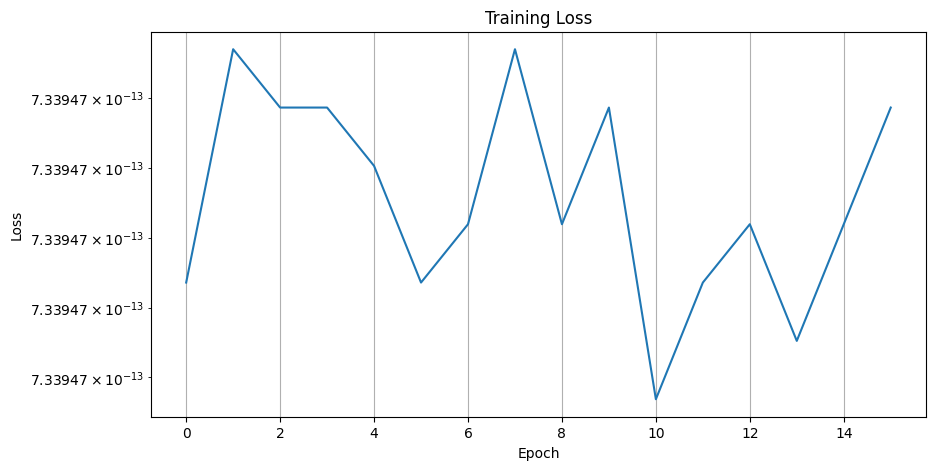

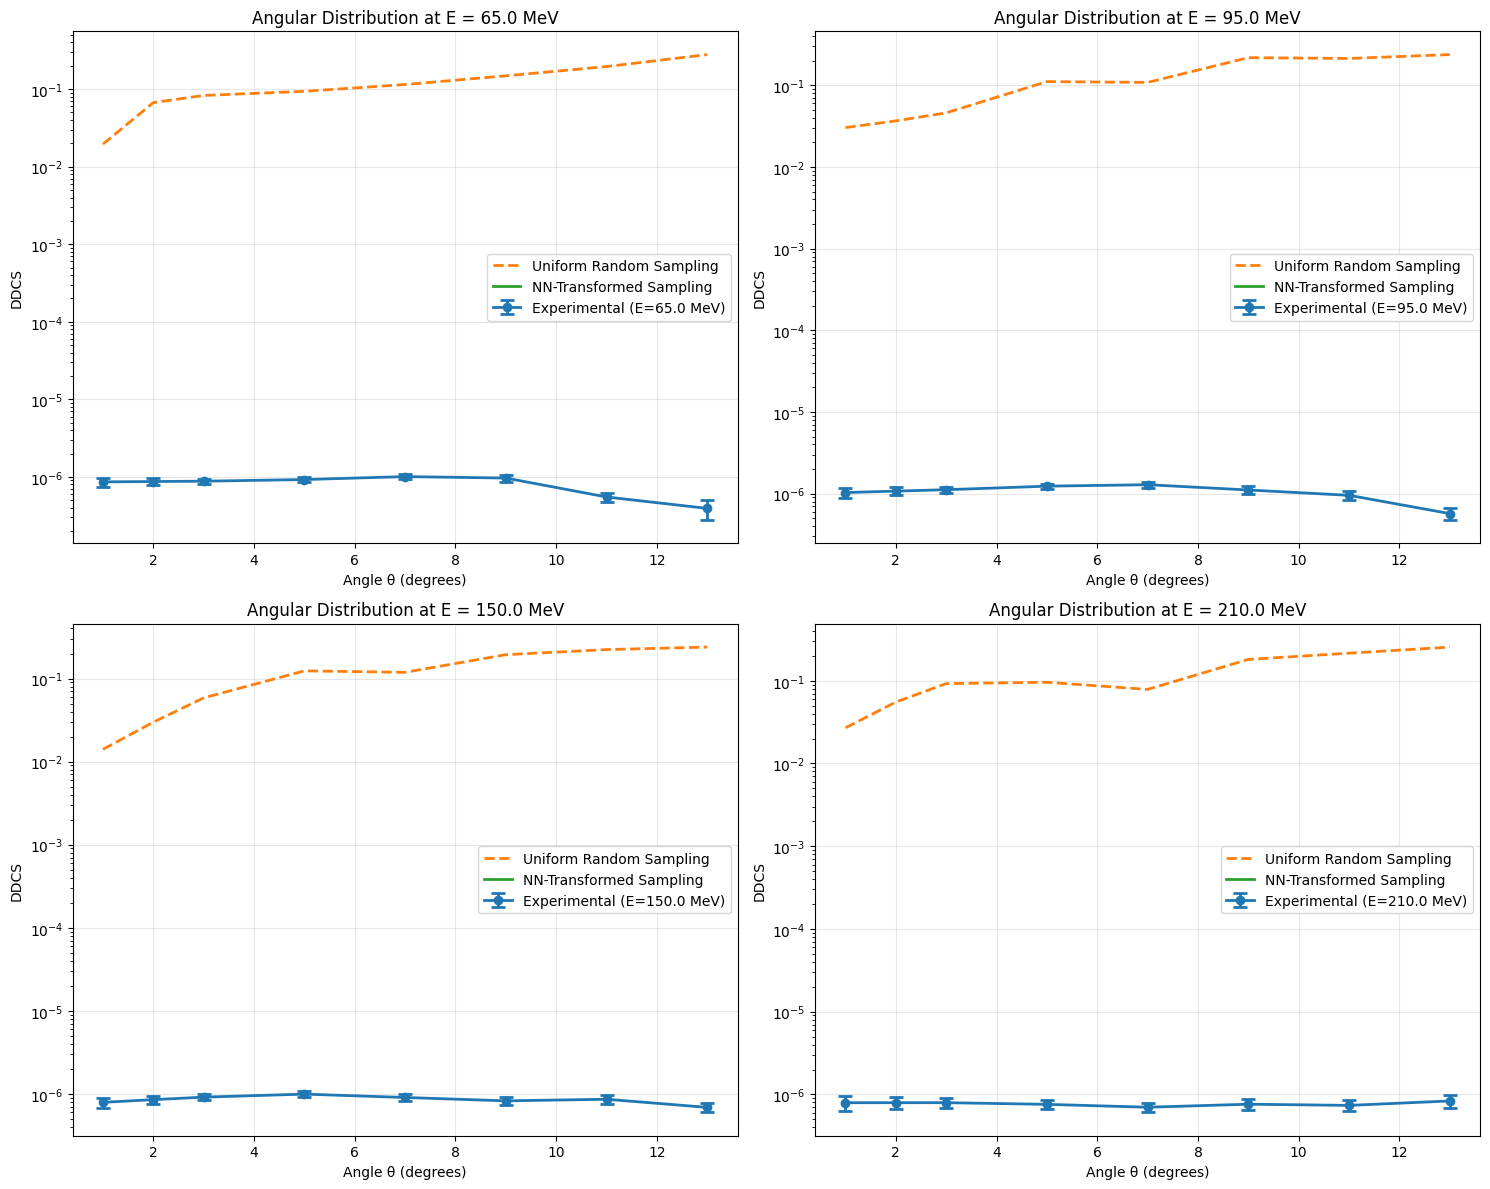

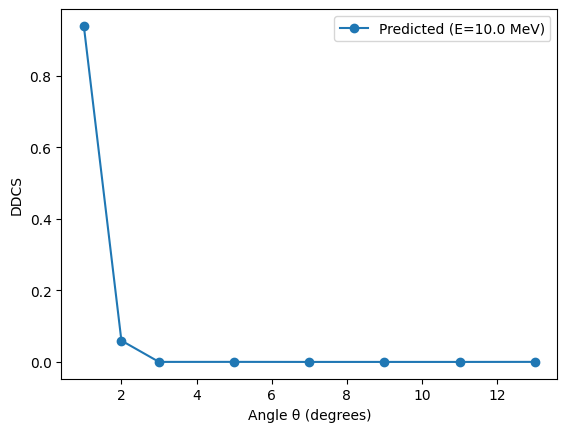

In [33]:
# Train the model
trainer = main_with_experimental_data(df)

theta_values=np.array([1,2,3,5,7,9,11,13])

# Use the trained model to predict DDCS for any energy
predicted_ddcs = predict_ddcs(trainer, E_incident=65000000, theta_values=theta_values)

# Plot prediction
plt.figure()
plt.plot(theta_values, predicted_ddcs, 'o-', label=f'Predicted (E=10.0 MeV)')
plt.xlabel('Angle θ (degrees)')
plt.ylabel('DDCS')
plt.legend()
plt.show()